# IBS with ANCOM-BC, scCODA and LinDA - Meta-analysis

We used ANCOM-BC, scCODA and LinDA on a whole number of different datasets - time for a meta-analysis!!


In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import importlib

import DA_analysis_util_functions as util

import warnings
warnings.filterwarnings("ignore")

Load data

In [2]:
# load results
data_dir = "../../../data/analysis-combined/10_DA-analysis/"

authors = ["Fukui", "Hugerth", "Labus", "LoPresti", "Nagel", "Pozuelo", "Zeber", "Zhu", "Zhuang", "Liu", "AGP", "Mars"]
tax_levels = ["Kingdom", "Phylum", "Class", "Order", "Family", "Genus"]

author_adds = {
    "Fukui": [None],
    "Hugerth": ["stool", "sigmoid"],
    "Labus": [None],
    "LoPresti": ["stool", "sigmoid"],
    "Nagel": [None],
    "Pozuelo": ["1st"],
    "Zeber": [None],
    "Zhu": [None],
    "Zhuang": [None],
    "Mars": ["1st", "2nd"],
    "Liu": [None],
    "AGP": [None],
}

## Prepare data for ANCOM-BC

We want to restrict ourselves to only stool samples:


In [3]:
alpha=0.2
ancombc_dict = util.read_authors_results(authors, data_dir, "ANCOMBC", alpha=alpha, adds=author_adds, run_no=1)
ancombc_stool = {}
for l in tax_levels[1:]:
    ancombc_stool[l] = ancombc_dict[l][ancombc_dict[l]["source"] == "stool"]
    ancombc_stool[l]["model"] = "ANCOM-BC"
    ancombc_stool[l]["effect"] = ancombc_stool[l]["beta"] * ancombc_stool[l]["diff_abn"]
ancombc_res= util.get_significances(ancombc_stool, "ANCOM-BC")

## Now with scCODA

In [4]:
alpha=0.2
sccoda_dict = util.read_authors_results(authors, data_dir, "sccoda", alpha=alpha, adds=author_adds, run_no=2)
sccoda_stool = {}
for l in tax_levels[1:]:
    sccoda_stool[l] = sccoda_dict[l][sccoda_dict[l]["source"] == "stool"]
    sccoda_stool[l]["model"] = "scCODA"
sccoda_res= util.get_significances(sccoda_stool, "scCODA")

## Now with LinDA

In [5]:
alpha=0.2
linda_dict = util.read_authors_results(authors, data_dir, "LinDA", alpha=alpha, adds=author_adds, run_no=1)
linda_stool = {}
for l in tax_levels[1:]:
    linda_stool[l] = linda_dict[l][linda_dict[l]["source"] == "stool"]
    linda_stool[l]["model"] = "LinDA"

linda_res= util.get_significances(linda_stool, "LinDA")

## Comparison barplots

Figure 4 A/B; Figure S8

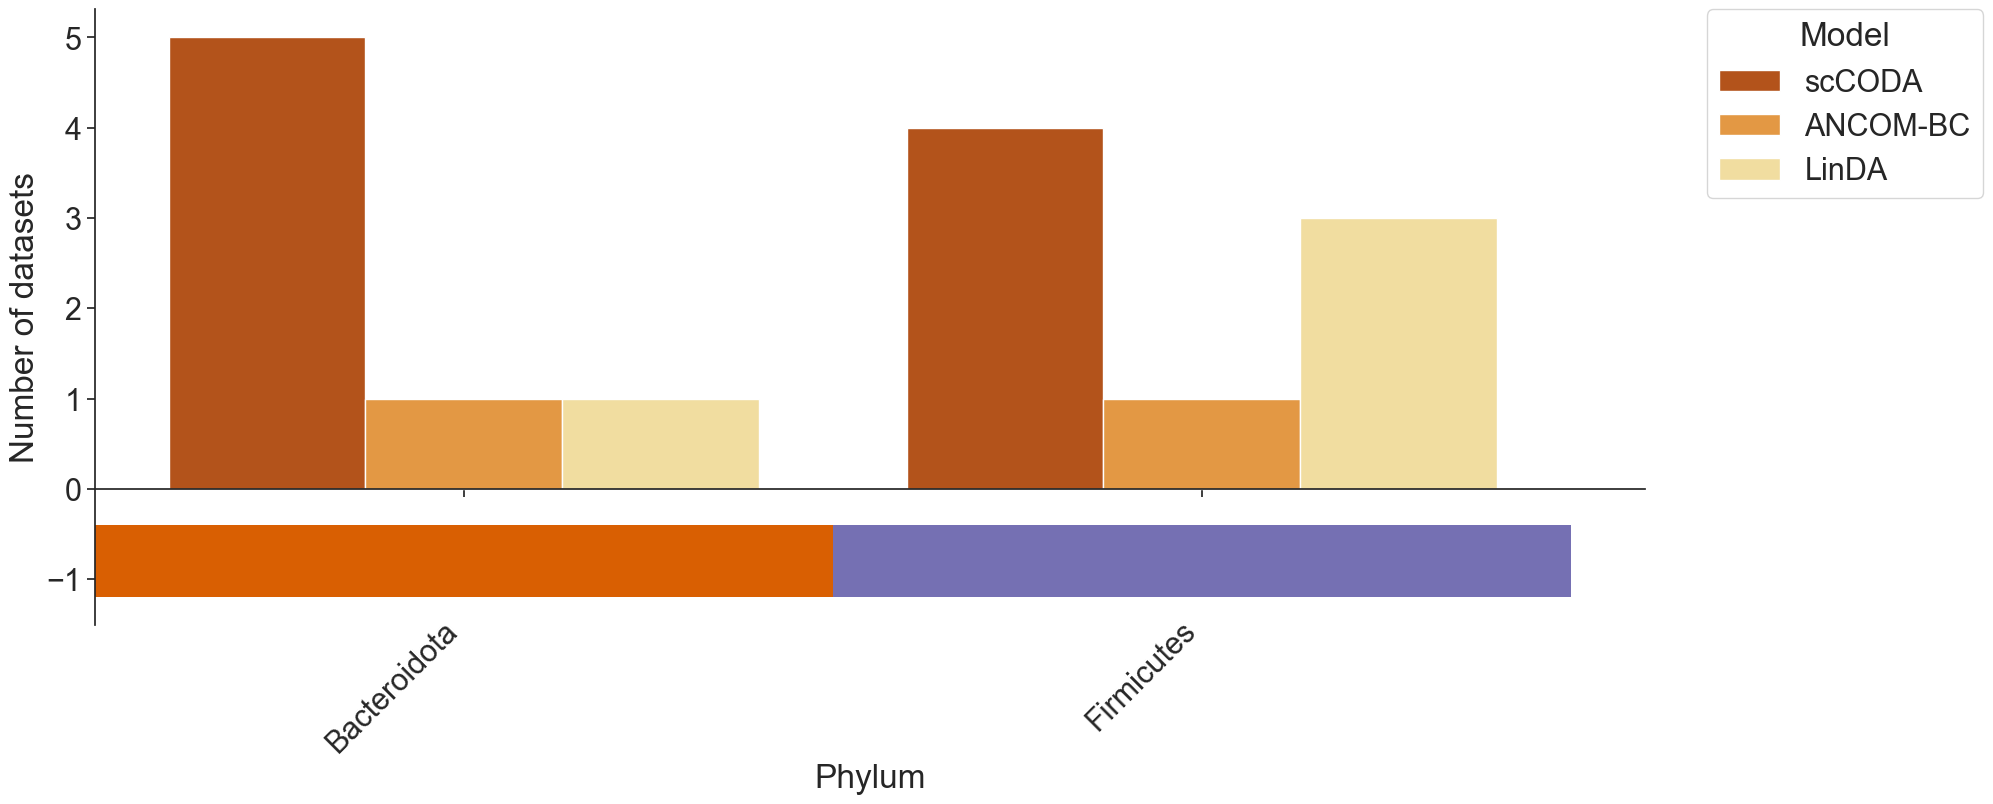

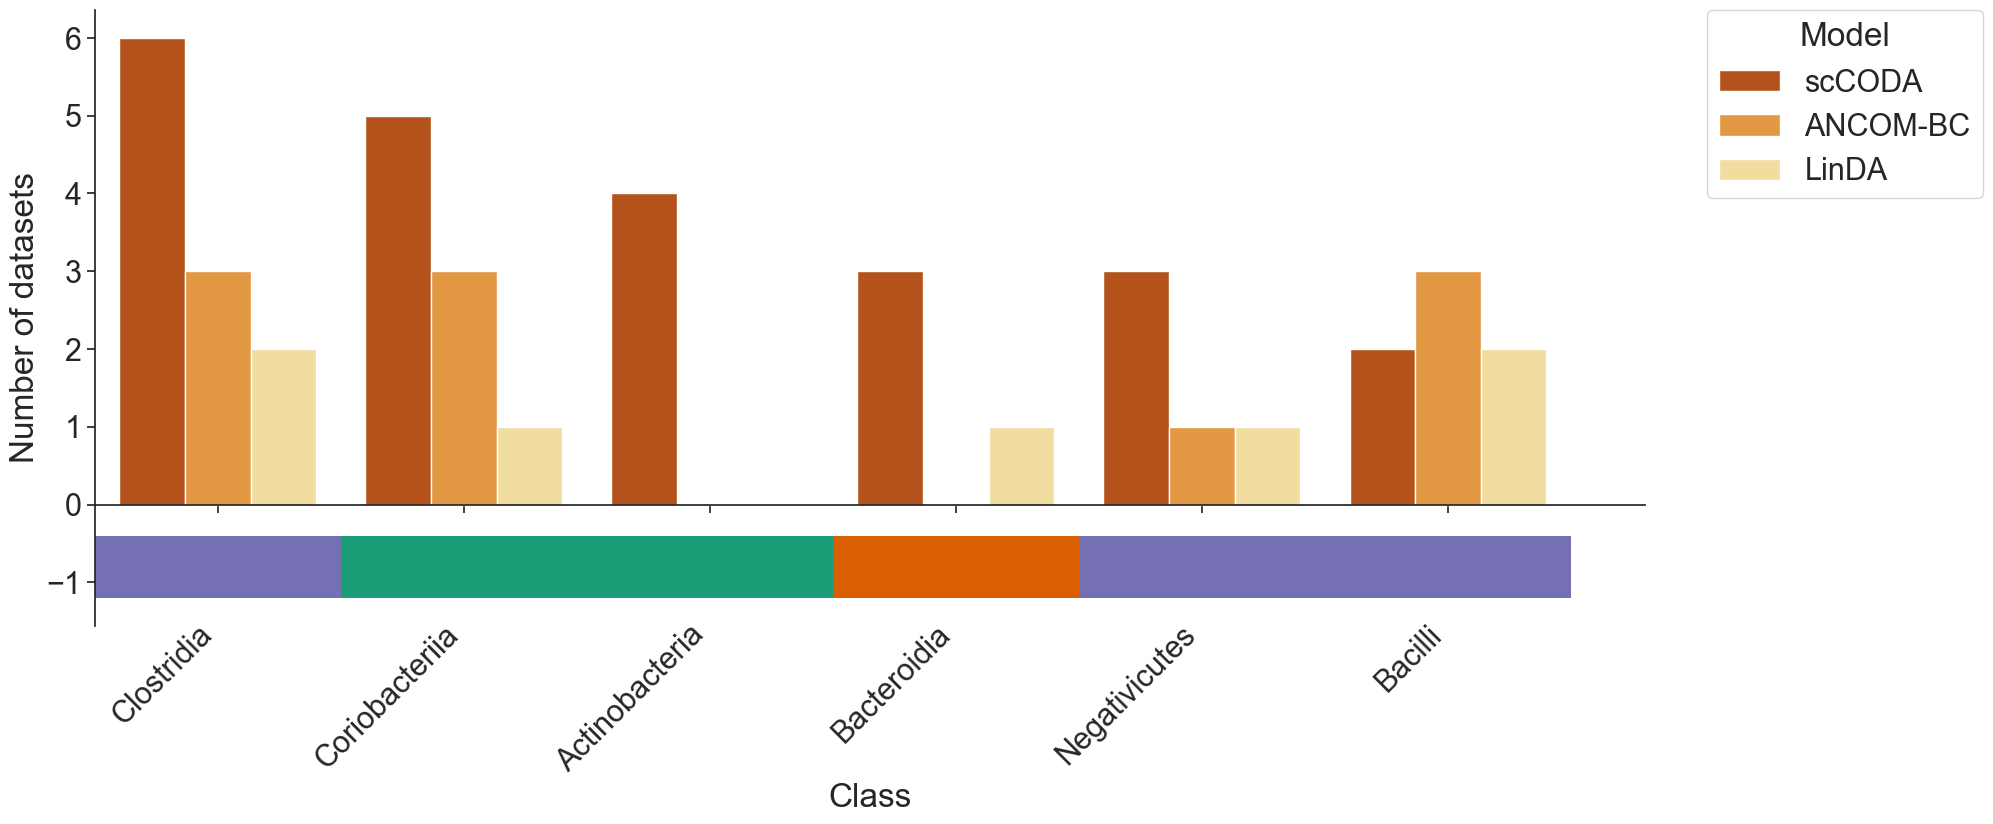

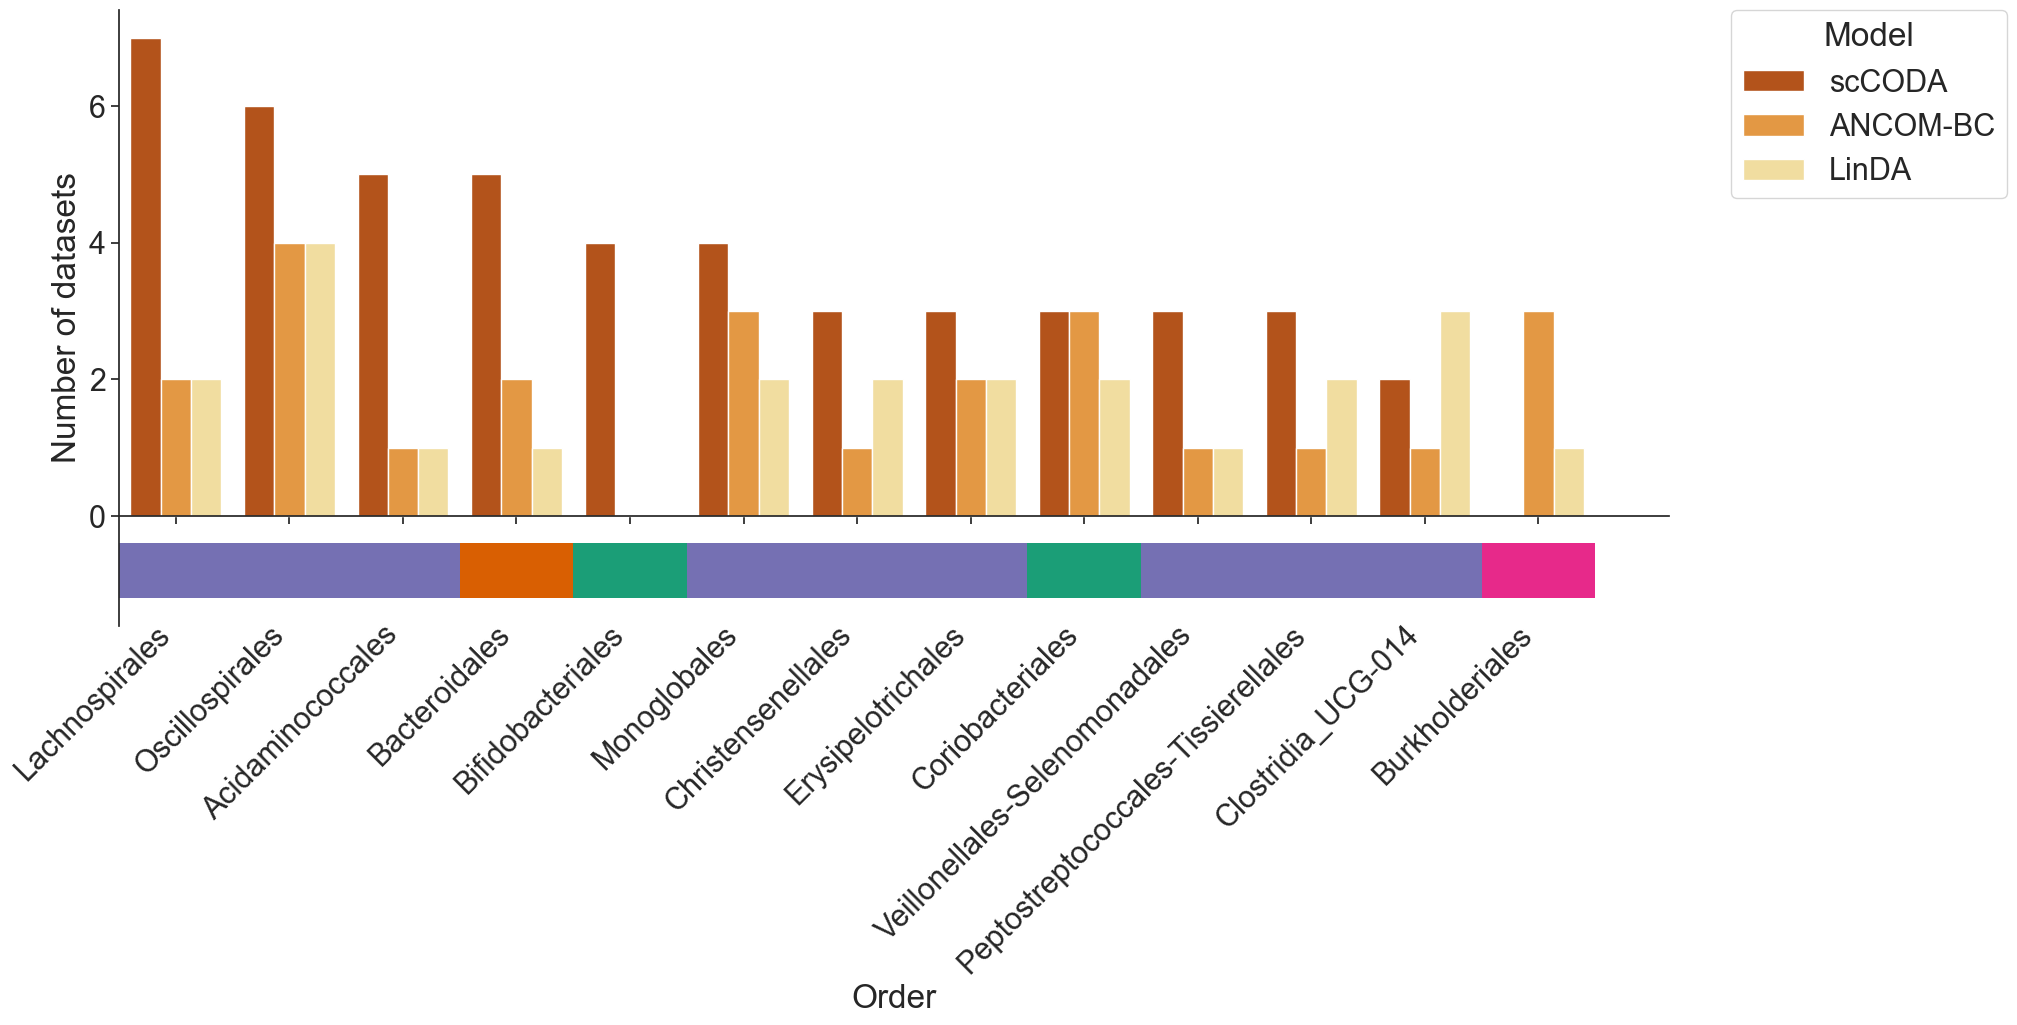

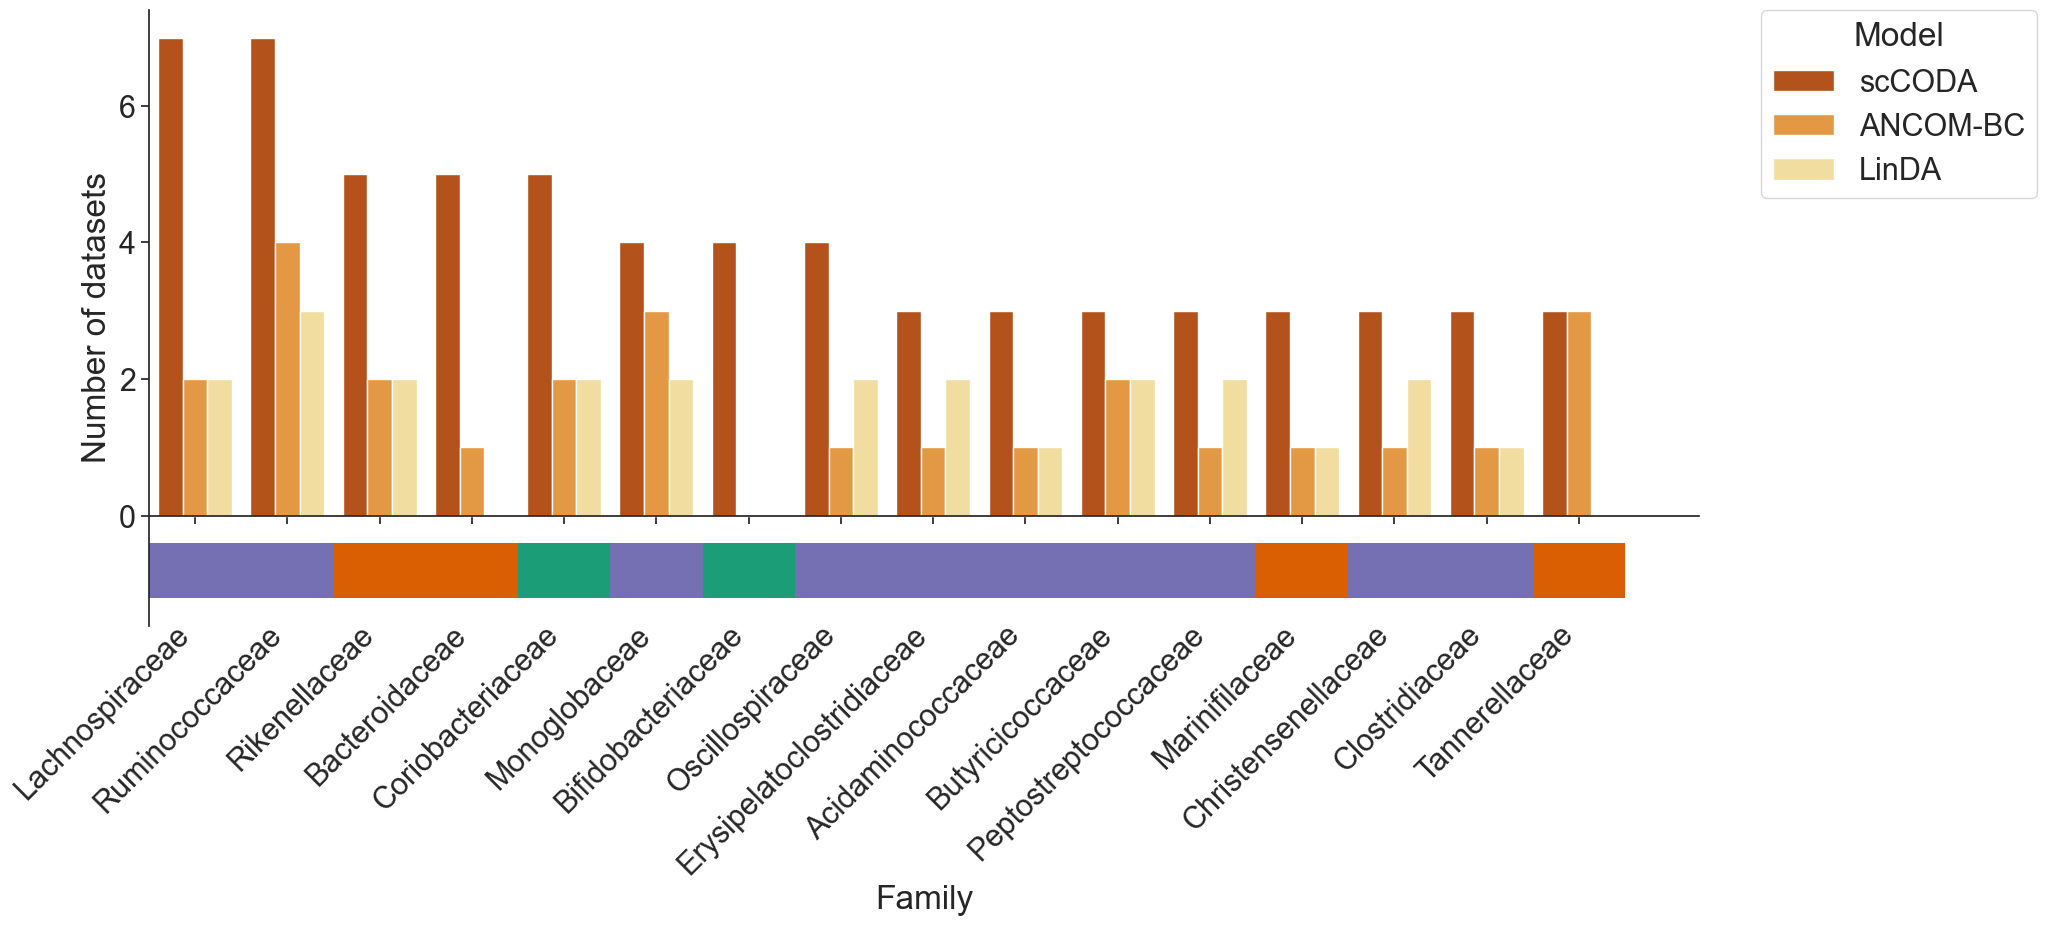

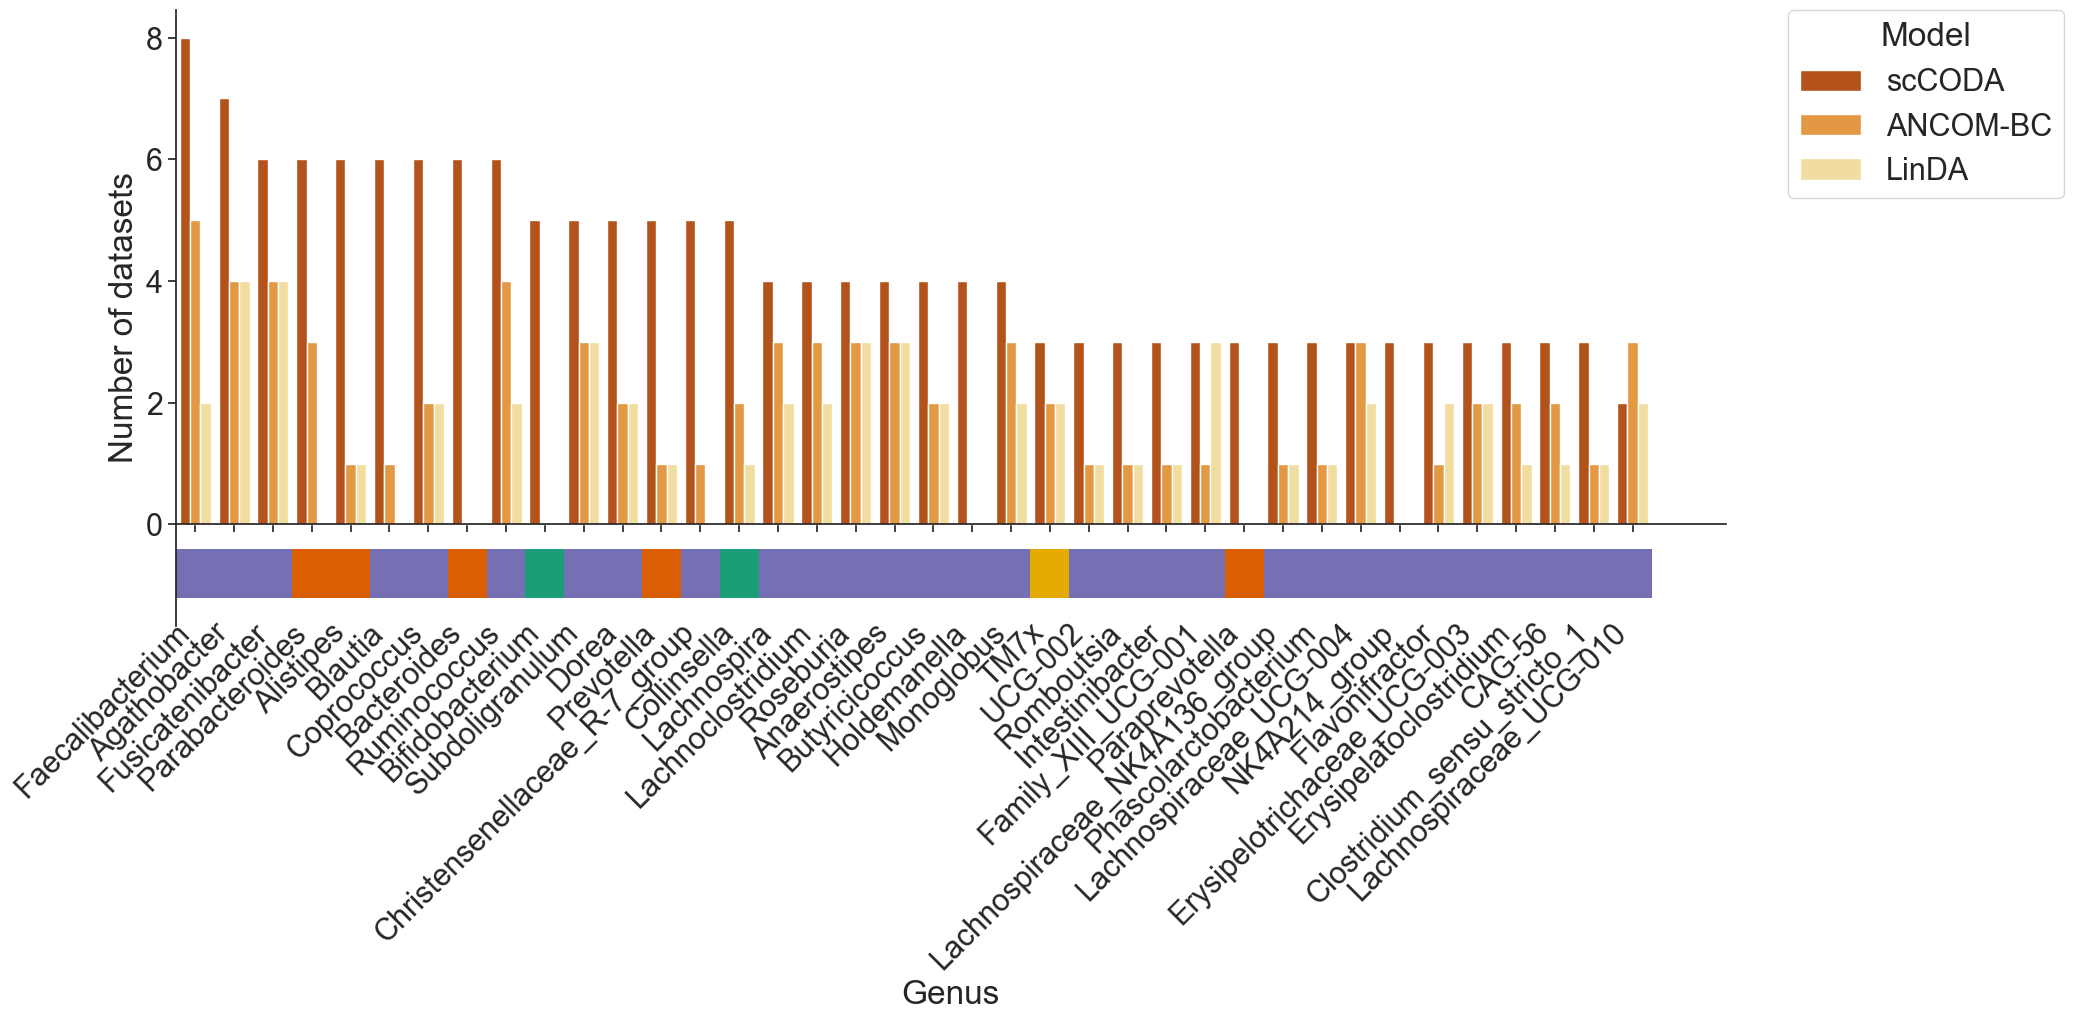

In [6]:
ecd = {
        "Firmicutes": "#7570B3",
        "Proteobacteria": "#E7298A",
        "Bacteroidota": "#D95F02",
        "Actinobacteriota": "#1B9E77",
        "Verrucomicrobiota": "#66A61E",
    }

for l in tax_levels[1:]:
    plot_df = pd.concat([
        sccoda_res[l].reset_index().sort_values("count", ascending=False),
        ancombc_res[l].reset_index().sort_values("count", ascending=False),
        linda_res[l].reset_index().sort_values("count", ascending=False),

    ]).reset_index()

    leq3_groups = list(pd.unique(plot_df.loc[plot_df["count"] >= 3, l]))
    leq3_phy = dict(zip(leq3_groups, [plot_df.loc[plot_df[l] == x, "Phylum"].iloc[0] for x in leq3_groups]))

    # plt.figure(figsize=(12, 6))
    sns.set(rc={'figure.figsize':(20, 8)}, font_scale=2)
    sns.set_style("ticks")

    plt.figure(figsize=(20, 8))
    g = sns.barplot(data=plot_df[plot_df[l].isin(leq3_groups)], x=l, y="count", hue="model", palette="YlOrBr_r")

    plt.legend(
        bbox_to_anchor=(1.04, 1),
        loc=2,
        borderaxespad=0.,
        title="Model",
    )

    lab_cols = [ecd[leq3_phy[x.get_text()]] if leq3_phy[x.get_text()] in ecd.keys() else "#E6AB02" for x in plt.gca().get_xticklabels()]
    gen_interest = [x.get_text() for x in plt.gca().get_xticklabels()]
    for i in range(len(lab_cols)):
        plt.barh(y=-0.8, width=len(lab_cols)-i, color=lab_cols[-(i+1)], left=-0.5, lw=0)

    g.spines['bottom'].set_position('zero')
    plt.xticks(rotation=45, ha="right")
    g.tick_params(axis="x", pad=125-8*np.max(plot_df["count"]))

    sns.despine()
    plt.ylabel("Number of datasets")

    # plt.savefig(f"../../../data/analysis-combined/10_DA-analysis/DA_plots/bars_stool_comparison_0.2_{l}_v3.svg", bbox_inches="tight", format="svg")
    # plt.savefig(f"../../../data/analysis-combined/10_DA-analysis/DA_plots/bars_stool_comparison_0.2_{l}_v3.png", bbox_inches="tight", format="png")
    plt.show()

Get taxa that are DA in at least 3 datasets for at least one method

In [7]:

plot_df = pd.concat([
    sccoda_res["Genus"].reset_index().sort_values("count", ascending=False),
    ancombc_res["Genus"].reset_index().sort_values("count", ascending=False),
    linda_res["Genus"].reset_index().sort_values("count", ascending=False),

]).reset_index()

leq3_groups = pd.unique(plot_df.loc[plot_df["count"] >= 3, l])


## Three-color heatmap

Figure 4 C

In [8]:

leq_df_sccoda = sccoda_stool["Genus"][sccoda_stool["Genus"][l].isin(leq3_groups)]
leq_df_sccoda["temp"] = np.sign(leq_df_sccoda["Final Parameter"]).astype("float")*3
hm_df_sccoda = leq_df_sccoda.pivot("Genus", "author", "temp").astype(float).fillna(-4)
hm_df_sccoda.columns = [x + "_1sccoda " for x in hm_df_sccoda.columns]

leq_df_ancombc = ancombc_stool["Genus"][ancombc_stool["Genus"][l].isin(leq3_groups)]
leq_df_ancombc["temp"] = np.sign(leq_df_ancombc["effect"]).astype("float")*2
hm_df_ancombc = leq_df_ancombc.pivot("Genus", "author", "temp").astype(float).fillna(-4)
hm_df_ancombc.columns = [x + "_2ancombc " for x in hm_df_ancombc.columns]

leq_df_linda = linda_stool["Genus"][linda_stool["Genus"][l].isin(leq3_groups)]
leq_df_linda["temp"] = np.sign(leq_df_linda["eff"]).astype("float")
hm_df_linda = leq_df_linda.pivot("Genus", "author", "temp").astype(float).fillna(-4)
hm_df_linda.columns = [x + "_3linda " for x in hm_df_linda.columns]

hm_df_all = pd.merge(pd.merge(hm_df_sccoda, hm_df_ancombc, left_index=True, right_index=True), hm_df_linda, left_index=True, right_index=True)
hm_df_all = hm_df_all.reindex(sorted(hm_df_all.columns), axis=1)
hm_df_all = hm_df_all.reindex(gen_interest, axis=0)
hm_df_all

,AGP_1sccoda,AGP_2ancombc,AGP_3linda,Fukui_1sccoda,Fukui_2ancombc,Fukui_3linda,Hugerth_1sccoda,Hugerth_2ancombc,Hugerth_3linda,Labus_1sccoda,...,Pozuelo_3linda,Zeber_1sccoda,Zeber_2ancombc,Zeber_3linda,Zhu_1sccoda,Zhu_2ancombc,Zhu_3linda,Zhuang_1sccoda,Zhuang_2ancombc,Zhuang_3linda
Genus,,,,,,,,,,,,,,,,,,,,,
Faecalibacterium,-3.0,-2.0,-1.0,-3.0,-2.0,0.0,-3.0,0.0,0.0,-3.0,...,0.0,-3.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0
Agathobacter,-3.0,-2.0,-1.0,-3.0,-2.0,-1.0,-3.0,0.0,0.0,-3.0,...,0.0,-3.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
Fusicatenibacter,-3.0,-2.0,-1.0,-3.0,-2.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,-3.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0
Parabacteroides,3.0,0.0,0.0,-3.0,-2.0,0.0,-3.0,0.0,0.0,-3.0,...,0.0,-3.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0
Alistipes,3.0,0.0,0.0,-3.0,-2.0,0.0,-3.0,0.0,0.0,-3.0,...,0.0,-3.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
Blautia,-3.0,0.0,0.0,-3.0,0.0,0.0,-3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0
Coprococcus,-3.0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,...,-1.0,-3.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0
Bacteroides,3.0,0.0,0.0,-3.0,0.0,0.0,-3.0,0.0,0.0,-3.0,...,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ruminococcus,3.0,0.0,0.0,-3.0,-2.0,-1.0,0.0,0.0,0.0,-3.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,0.0,0.0


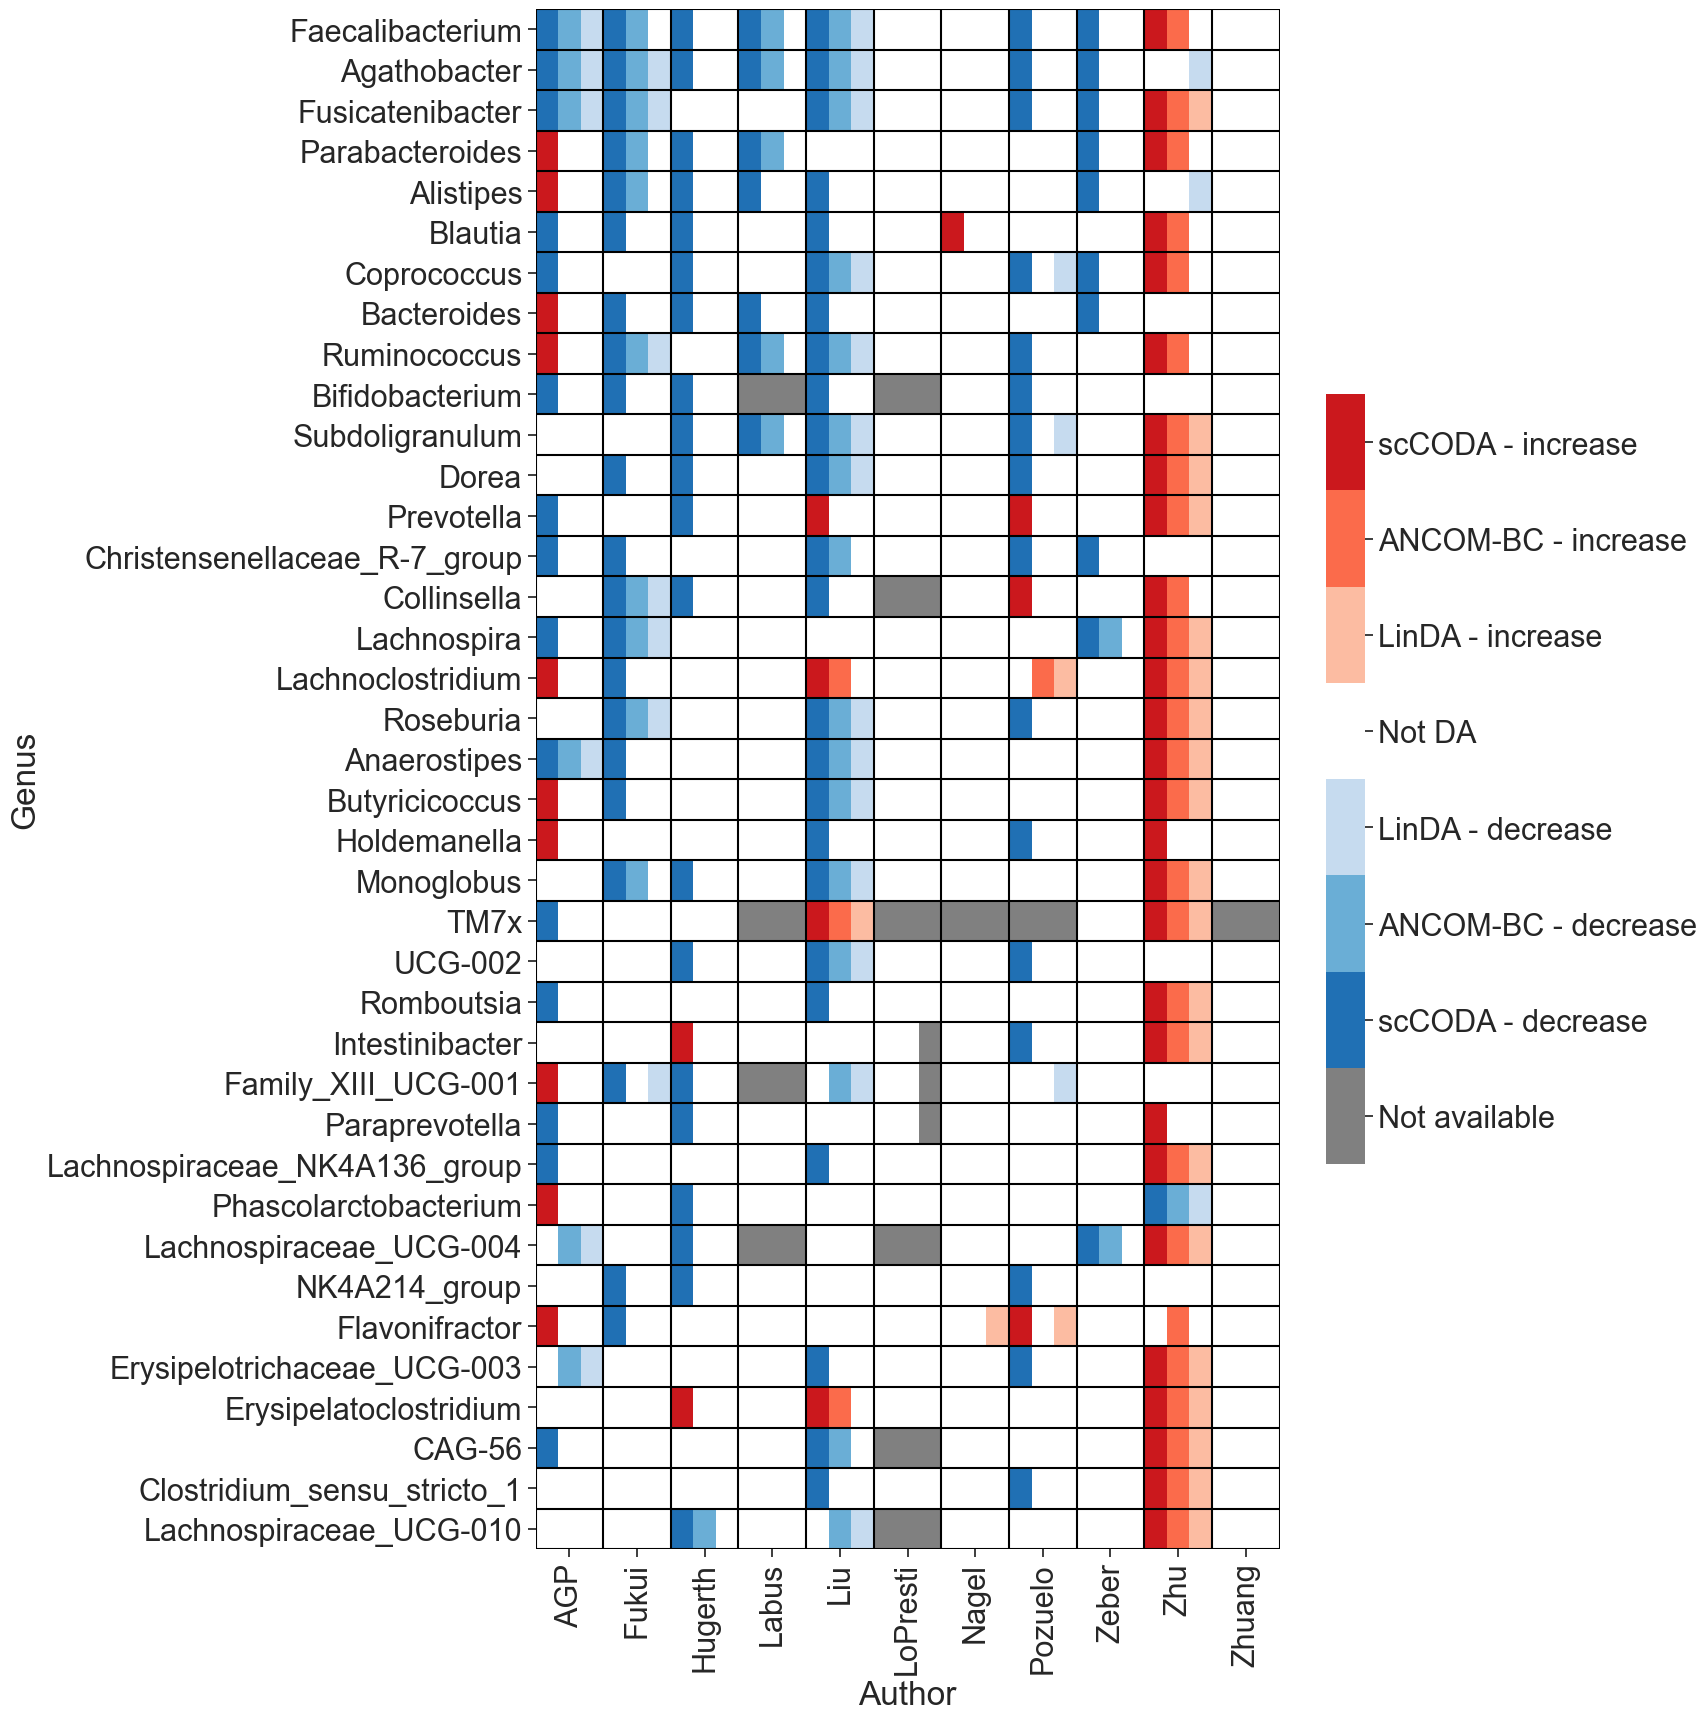

In [9]:
cmap = ["grey"] + [sns.color_palette("Blues", 3)[2], sns.color_palette("Blues", 3)[1], sns.color_palette("Blues", 3)[0]] + ["white"] + [sns.color_palette("Reds_r", 3)[2], sns.color_palette("Reds_r", 3)[1], sns.color_palette("Reds_r", 3)[0]]
plt.figure(figsize=(12, 20))

authors_ = ["AGP", "Fukui", "Hugerth", "Labus", "Liu", "LoPresti", "Nagel", "Pozuelo", "Zeber", "Zhu", "Zhuang"]

ax = sns.heatmap(data=hm_df_all, cmap=cmap, yticklabels=1, linewidths=0, cbar_kws={"shrink": 0.5})
ax.vlines([3*x for x in range(12)], *ax.get_ylim(), color="black")
ax.hlines([x for x in range(len(hm_df_all)+1)], *ax.get_xlim(), color="black")

colorbar = ax.collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + r / 8 * (0.5 + i) for i in range(8)])
colorbar.set_ticklabels(["Not available", "scCODA - decrease", "ANCOM-BC - decrease", "LinDA - decrease", "Not DA", "LinDA - increase", "ANCOM-BC - increase", "scCODA - increase"])

plt.xticks([3*x+1.5 for x in range(11)], authors_)
plt.xlabel("Author")

# plt.savefig(f"../../../data/analysis-combined/10_DA-analysis/DA_plots/three_color_heatmap_dir_v2.svg", bbox_inches="tight", format="svg")
# plt.savefig(f"../../../data/analysis-combined/10_DA-analysis/DA_plots/three_color_heatmap_dir_v2.png", bbox_inches="tight", format="png")

plt.show()

# Tree plot (scCODA)

Figure 4 D

In [10]:
all_data = []
for a in authors:
    print(a)
    adds = author_adds[a]
    for add in adds:
        print(add)
        data = util.read_authors_results([a], data_dir, method="sccoda", adds={a: [add]}, alpha=0.2, run_no=2)
        data_stool = {}
        for l in tax_levels[1:]:
            data_stool[l] = data[l][data[l]["source"] == "stool"]
        all_data.append(data_stool)

# Add Mars data for universal tree (1st and 2nd timepoint have the same genera)
dat_mars = util.read_authors_results(["Mars"], data_dir, method="sccoda", adds={"Mars": ["1st"]}, alpha=0.2, run_no=2)
for x in dat_mars.values():
    x["Final Parameter"] = 0.
    x["Is credible"] = False

# print(dat_mars)
all_data.append(dat_mars)


Fukui
None
Hugerth
stool
sigmoid
Labus
None
LoPresti
stool
sigmoid
Nagel
None
Pozuelo
1st
Zeber
None
Zhu
None
Zhuang
None
Liu
None
AGP
None
Mars
1st
2nd


In [11]:
presence_min = 1
sum_sigs_pres = {}
levs = ["Cell Type", "Kingdom"]
for l in tax_levels[1:]:
    levs.append(l)
    dat = pd.concat([d[l] for d in all_data])
    sum = dat.groupby(levs).agg({
        "Is credible": lambda x: np.sum(x),
        "SD": "count"
    }).rename(columns={"Is credible": "Final Parameter"})

    sum_sigs_pres[l] = sum[sum["SD"] >= presence_min].reset_index()


In [12]:
sum_sigs_pres["Genus"]

,Cell Type,Kingdom,Phylum,Class,Order,Family,Genus,Final Parameter,SD
0,Archaea*Crenarchaeota*Nitrososphaeria*Nitrosos...,Archaea,Crenarchaeota,Nitrososphaeria,Nitrososphaerales,Nitrososphaeraceae,Candidatus_Nitrososphaera,1,1
1,Archaea*Euryarchaeota*Methanobacteria*Methanob...,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,0,6
2,Archaea*Euryarchaeota*Methanobacteria*Methanob...,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,2,3
3,Archaea*Euryarchaeota*Methanobacteria*Methanob...,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanothermobacteriaceae,Methanothermobacter,0,1
4,Archaea*Thermoplasmatota*Thermoplasmata*Methan...,Archaea,Thermoplasmatota,Thermoplasmata,Methanomassiliicoccales,Methanomassiliicoccaceae,Methanomassiliicoccus,0,3
...,...,...,...,...,...,...,...,...,...
972,Bacteria*Verrucomicrobiota*Verrucomicrobiae*Pe...,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Pedosphaerales,Pedosphaeraceae,Ellin517,0,1
973,Bacteria*Verrucomicrobiota*Verrucomicrobiae*Pe...,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Pedosphaerales,Pedosphaeraceae,SH3-11,0,1
974,Bacteria*Verrucomicrobiota*Verrucomicrobiae*Ve...,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,1,11
975,Bacteria*Verrucomicrobiota*Verrucomicrobiae*Ve...,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Verrucomicrobiales,Rubritaleaceae,Luteolibacter,1,2


In [13]:
import toyplot.svg
import toyplot.png
import toyplot.color
import toyplot.marker

importlib.reload(util)

# palette = toyplot.color.brewer.palette("Set1")
ecd = {
    "Firmicutes": "#7570B3",
    "Proteobacteria": "#E7298A",
    "Bacteroidota": "#D95F02",
    "Actinobacteriota": "#1B9E77",
    "Verrucomicrobiota": "#66A61E",
}

l = "Genus"
leq_df = pd.concat([
        sccoda_res["Genus"].reset_index().sort_values("count", ascending=False),
        ancombc_res["Genus"].reset_index().sort_values("count", ascending=False),
        linda_res["Genus"].reset_index().sort_values("count", ascending=False),

    ]).reset_index()

leq3_groups = pd.unique(leq_df.loc[leq_df["count"] >= 3, "Genus"])

tre_all_pres, markers = util.build_fancy_tree(sum_sigs_pres, edge_color_dict=ecd, other_col="#E6AB02")

In [14]:
canvas = toyplot.Canvas(width=1000, height=800)
ax0 = canvas.cartesian(bounds=(0, 800, 0, 800), padding=15)
ax0.show = False

max_eff = np.max([n.effect for n in tre_all_pres.treenode.traverse()])
node_pal = toyplot.color.brewer.map("Greys", count=max_eff, domain_min=1, domain_max=max_eff)

for node in tre_all_pres.treenode.traverse():
    node.color = node_pal.colors(node.effect)

tre_all_pres.draw(
    axes=ax0,
    layout='c',
    edge_type='p',
    node_sizes=[np.abs(n.effect)*3 for n in tre_all_pres.treenode.traverse()],
    node_colors=[n.color for n in tre_all_pres.treenode.traverse()],
    # node_style={"fill": "blue"},
    width=800,
    height=800,
    node_style={
        "stroke": "black",
        "stroke-width": "1"
    },
    edge_style={
        "stroke-width": "0.8"
    },
    tip_labels=[t if t in leq3_groups else "" for t in tre_all_pres.get_tip_labels()],
    tip_labels_align=True,
    tip_labels_style={
        "font-size": "8px",
        "-toyplot-anchor-shift": "20pt"
    },
    edge_colors=[tre_all_pres.idx_dict[x[1]].edge_color for x in tre_all_pres.get_edges()],
)
label = "Combined - scCODA"
ax1 = canvas.cartesian(bounds=(50, 800, 50, 100), padding=15, label=label)
ax1.x.show=False
ax1.y.show=False


markers_ = markers[:-1]
markers_.reverse()
markers_.append(markers[-1])
markers__ = []

for l, m in markers_:
    m_ = toyplot.marker.create(
        shape="r2.5x0.5",
        size=8,
        mstyle={"fill": m.mstyle["fill"], "stroke-width": 0}
    )
    markers__.append((l, m_))

# print(markers__)

canvas.legend(markers__,
        bounds=(800, 900, 200, 300),
        label="Phylum"
)

ns = np.unique([np.abs(n.effect) for n in tre_all_pres.treenode.traverse()])

def get_col_str(color):
    col = np.round(np.array(color.tolist())*255, 0).astype(int).tolist()
    s = "rgba"+str(col).replace("[", "(").replace("]", ")").replace(" ", "")
    return s

markers2 = [(int(x),
             toyplot.marker.create(
                 shape="o",
                 size=x*3,
                 mstyle={"fill": get_col_str(node_pal.colors(x))}
             ))
            for x in ns[1:]]
canvas.legend(markers2,
        bounds=(800, 900, 350, 600),
        label="Number of datasets"
)
# toyplot.svg.render(canvas, f"../../../data/analysis-combined/10_DA-analysis/DA_plots/tree_stool_sccoda_0.2_v4.svg")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="800.0px" viewBox="0 0 1000.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tdd36e28f0ecd49128e8ad8746c57c28b"> <pat

# Legend for figure 4

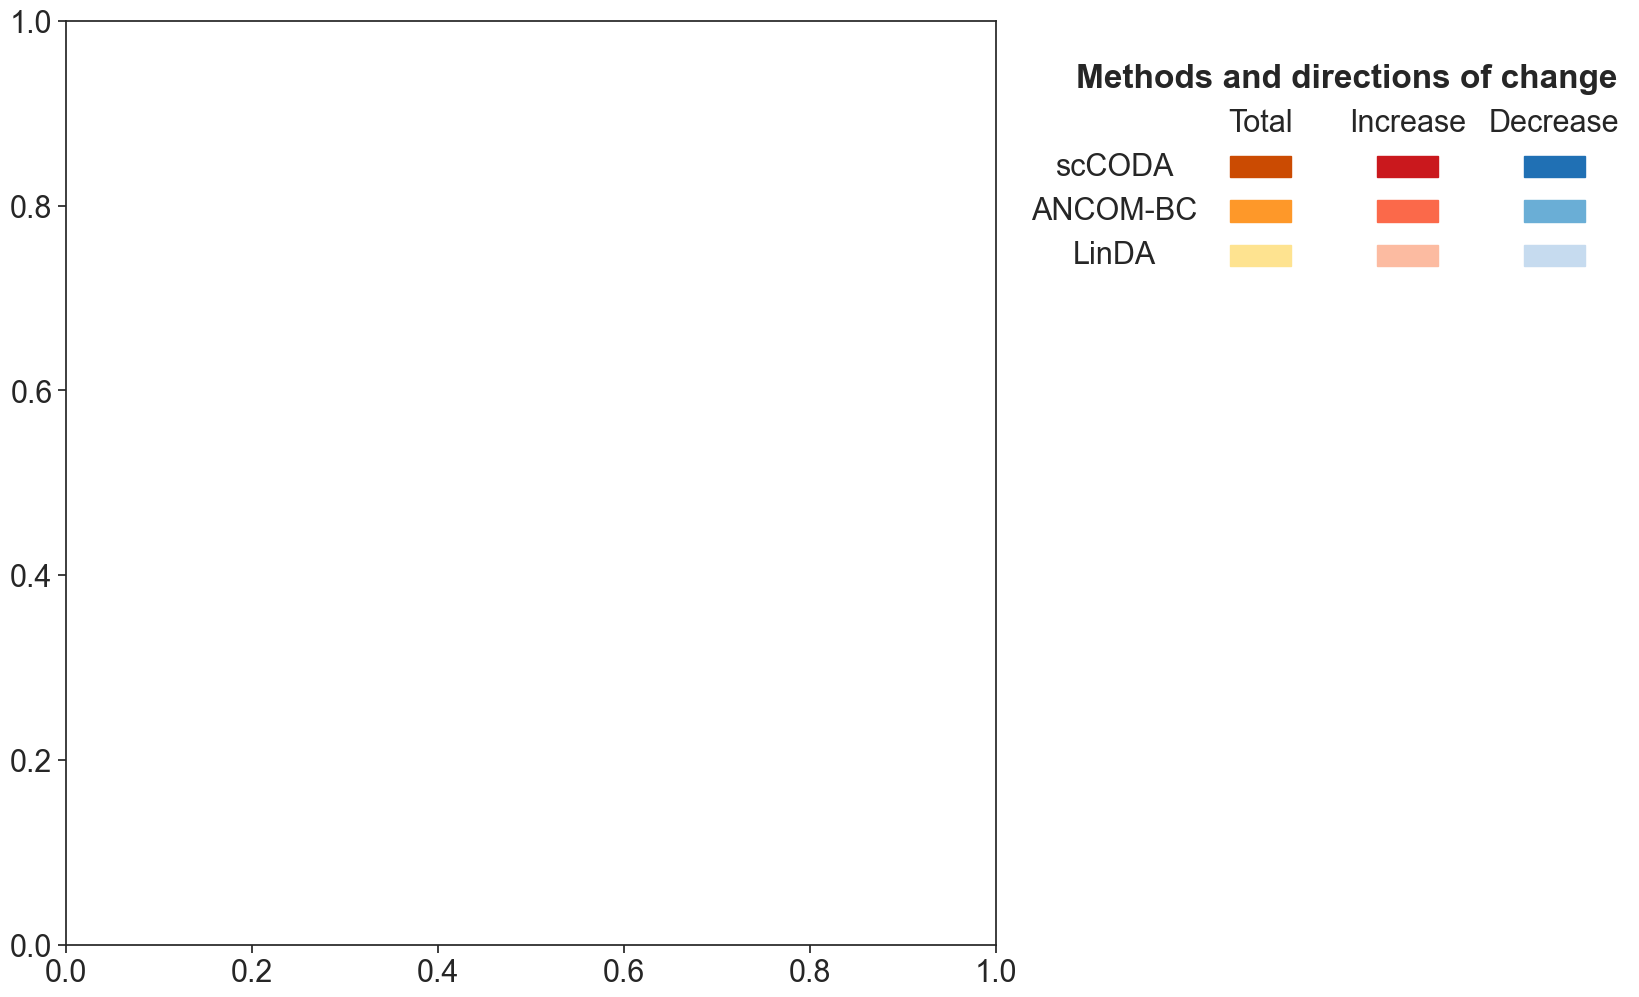

In [15]:
import matplotlib.patches as mpatches
import matplotlib.text as mpl_text
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase

fig, ax = plt.subplots(figsize=(12,12))

class AnyObject(object):
    def __init__(self, text, fw):
        self.my_text = text
        self.my_fw = fw

class TextHandlerA(HandlerBase):
    def create_artists(self, legend, text ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = mpl_text.Text(width/2., height/2, text, fontsize=fontsize,
                  ha="center", va="center")
        return [tx]

Legend.update_default_handler_map({str : TextHandlerA()})

leg_handles = [
    mpatches.Rectangle((0,0), 1, 1, color="white", label=''),
    "scCODA",
    "ANCOM-BC",
    "LinDA",
    "Total",
    mpatches.Patch(color=sns.color_palette("YlOrBr", 3)[2], label=''),
    mpatches.Patch(color=sns.color_palette("YlOrBr", 3)[1], label=''),
    mpatches.Patch(color=sns.color_palette("YlOrBr", 3)[0], label=''),
    "Increase",
    mpatches.Patch(color=sns.color_palette("Reds", 3)[2], label=''),
    mpatches.Patch(color=sns.color_palette("Reds", 3)[1], label=''),
    mpatches.Patch(color=sns.color_palette("Reds", 3)[0], label=''),
    "Decrease",
    mpatches.Patch(color=sns.color_palette("Blues", 3)[2], label=''),
    mpatches.Patch(color=sns.color_palette("Blues", 3)[1], label=''),
    mpatches.Patch(color=sns.color_palette("Blues", 3)[0], label=''),
]

leg_labels = ['' for i in range(len(leg_handles))]

leg = ax.legend(
    handles=leg_handles, labels=leg_labels,
    ncol=4, title="Methods and directions of change",
    frameon=False, title_fontproperties={'weight':'bold'},
    bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=1.,
)

# plt.savefig(f"../../../data/analysis-combined/10_DA-analysis/DA_plots/model_legend.svg", bbox_inches="tight", format="svg")
# plt.savefig(f"../../../data/analysis-combined/10_DA-analysis/DA_plots/model_legend.png", bbox_inches="tight", format="png")

plt.show()

# Legend for supplementary barplot (Figure S8)

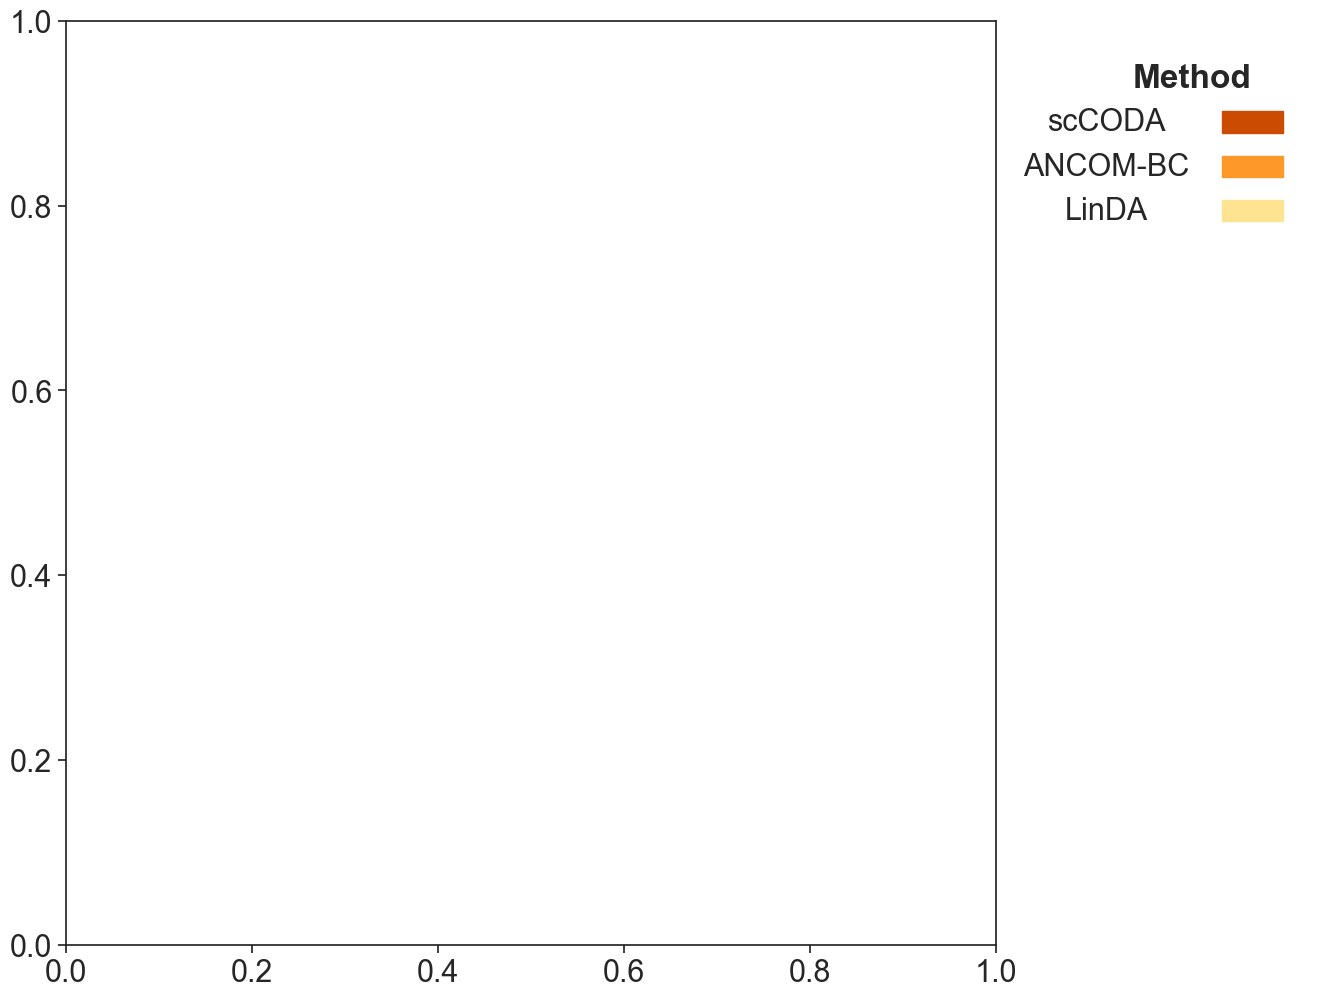

In [16]:
fig, ax = plt.subplots(figsize=(12,12))

leg_handles = [
    "scCODA",
    "ANCOM-BC",
    "LinDA",
    mpatches.Patch(color=sns.color_palette("YlOrBr", 3)[2], label=''),
    mpatches.Patch(color=sns.color_palette("YlOrBr", 3)[1], label=''),
    mpatches.Patch(color=sns.color_palette("YlOrBr", 3)[0], label=''),
]

leg_labels = ['' for i in range(len(leg_handles))]

leg = ax.legend(
    handles=leg_handles, labels=leg_labels,
    ncol=2, title="Method",
    frameon=False, title_fontproperties={'weight':'bold'},
    bbox_to_anchor=(1.04, 1), loc=2, borderaxespad=1.,
)

# plt.savefig(f"../../../data/analysis-combined/10_DA-analysis/DA_plots/model_legend_supp.svg", bbox_inches="tight", format="svg")
# plt.savefig(f"../../../data/analysis-combined/10_DA-analysis/DA_plots/model_legend_supp.png", bbox_inches="tight", format="png")

plt.show()


# Overview table (Table 2)

In [17]:
all_genus = pd.concat([sccoda_stool["Genus"], linda_stool["Genus"], ancombc_stool["Genus"]])
print(all_genus.columns)

Index(['Covariate', 'Cell Type', 'Final Parameter', 'HDI 3%', 'HDI 97%', 'SD',
       'Inclusion probability', 'Expected Sample', 'log2-fold change',
       'Is credible', 'author', 'source', 'Kingdom', 'Phylum', 'Class',
       'Order', 'Family', 'Genus', 'model', 'baseMean', 'log2FoldChange',
       'lfcSE', 'stat', 'pvalue', 'p_adj', 'reject', 'df', 'eff', 'beta', 'se',
       'W', 'p_val', 'q_val', 'diff_abn', 'struc_zero_0', 'struc_zero_1',
       'effect'],
      dtype='object')


In [18]:
gen_dataset = all_genus.groupby(["author", "model"]).agg({
    "source": "count",
    "Is credible": "sum"
})

gen_dataset["share"] = gen_dataset["Is credible"]/gen_dataset["source"]
gen_dataset.columns = ["Total genera", "DA genera", "Fraction"]
gen_dataset.index.names = ["First author", "Method"]
gen_dataset

Total genera  DA genera  Fraction
First author Method                                     
AGP          ANCOM-BC           620         16  0.025806
             LinDA              614         21  0.034202
             scCODA             620        197  0.317742
Fukui        ANCOM-BC           210         14  0.066667
             LinDA              210         10  0.047619
             scCODA             210         31  0.147619
Hugerth      ANCOM-BC           263          2  0.007605
             LinDA              262          0  0.000000
             scCODA             263         31  0.117871
Labus        ANCOM-BC            91          5  0.054945
             LinDA               91          0  0.000000
             scCODA              91          7  0.076923
Liu          ANCOM-BC           702        105  0.149573
             LinDA              702         42  0.059829
             scCODA             702         54  0.076923
LoPresti     ANCOM-BC            90          0  0.000000
             LinDA               83          0  0.000000
             scCODA              90          0  0.000000
Nagel        ANCOM-BC           163          3  0.018405
             LinDA              163          4  0.024540
             scCODA             163          1  0.006135
Pozuelo      ANCOM-BC           309          4  0.012945
             LinDA              309         11  0.035599
             scCODA             309         34  0.110032
Zeber        ANCOM-BC           236          4  0.016949
             LinDA              236          1  0.004237
             scCODA             236         13  0.055085
Zhu          ANCOM-BC           143         59  0.412587
             LinDA              143         65  0.454545
             scCODA             143         41  0.286713
Zhuang       ANCOM-BC           116          0  0.000000
             LinDA              116          0  0.000000
             scCODA             116          0  0.000000

In [19]:
print(gen_dataset.to_latex(float_format="%.3f"))


\begin{tabular}{llrrr}
\toprule
       &        &  Total genera &  DA genera &  Fraction \\
First author & Method &               &            &           \\
\midrule
AGP & ANCOM-BC &           620 &         16 &     0.026 \\
       & LinDA &           614 &         21 &     0.034 \\
       & scCODA &           620 &        197 &     0.318 \\
Fukui & ANCOM-BC &           210 &         14 &     0.067 \\
       & LinDA &           210 &         10 &     0.048 \\
       & scCODA &           210 &         31 &     0.148 \\
Hugerth & ANCOM-BC &           263 &          2 &     0.008 \\
       & LinDA &           262 &          0 &     0.000 \\
       & scCODA &           263 &         31 &     0.118 \\
Labus & ANCOM-BC &            91 &          5 &     0.055 \\
       & LinDA &            91 &          0 &     0.000 \\
       & scCODA &            91 &          7 &     0.077 \\
Liu & ANCOM-BC &           702 &        105 &     0.150 \\
       & LinDA &           702 &         42 &     0.06

# Tree plots (LinDA and ANCOM-BC)

Figure S9

In [20]:
all_data = []
for a in authors:
    print(a)
    adds = author_adds[a]
    for add in adds:
        print(add)
        data = util.read_authors_results([a], data_dir, method="ANCOMBC", adds={a: [add]}, alpha=0.2, run_no=1)
        data_stool = {}
        for l in tax_levels[1:]:
            data_stool[l] = data[l][data[l]["source"] == "stool"]
        all_data.append(data_stool)

Fukui
None
Hugerth
stool
sigmoid
Labus
None
LoPresti
stool
sigmoid
Nagel
None
Pozuelo
1st
Zeber
None
Zhu
None
Zhuang
None
Liu
None
AGP
None
Mars
1st
2nd


In [21]:
presence_min = 1
sum_sigs_pres = {}
levs = ["Cell Type", "Kingdom"]
for l in tax_levels[1:]:
    levs.append(l)
    dat = pd.concat([d[l] for d in all_data])
    sum = dat.groupby(levs).agg({
        "Is credible": lambda x: np.sum(x),
        "se": "count"
    }).rename(columns={"Is credible": "Final Parameter"})

    sum_sigs_pres[l] = sum[sum["se"] >= presence_min].reset_index()

In [22]:
import toyplot.svg
import toyplot.png
import toyplot.color
import toyplot.marker

importlib.reload(util)

# palette = toyplot.color.brewer.palette("Set1")
ecd = {
    "Firmicutes": "#7570B3",
    "Proteobacteria": "#E7298A",
    "Bacteroidota": "#D95F02",
    "Actinobacteriota": "#1B9E77",
    "Verrucomicrobiota": "#66A61E",
}

tre_all_pres, markers = util.build_fancy_tree(sum_sigs_pres, edge_color_dict=ecd, other_col="#E6AB02")

canvas = toyplot.Canvas(width=1000, height=800)
ax0 = canvas.cartesian(bounds=(0, 800, 0, 800), padding=15)
ax0.show = False

max_eff = 8
node_pal = toyplot.color.brewer.map("Greys", count=max_eff, domain_min=1, domain_max=max_eff)

for node in tre_all_pres.treenode.traverse():
    node.color = node_pal.colors(node.effect)

tre_all_pres.draw(
    axes=ax0,
    layout='c',
    edge_type='p',
    node_sizes=[np.abs(n.effect)*3 for n in tre_all_pres.treenode.traverse()],
    node_colors=[n.color for n in tre_all_pres.treenode.traverse()],
    # node_style={"fill": "blue"},
    width=800,
    height=800,
    node_style={
        "stroke": "black",
        "stroke-width": "1"
    },
    edge_style={
        "stroke-width": "0.8"
    },
    tip_labels=[t if t in leq3_groups else "" for t in tre_all_pres.get_tip_labels()],
    tip_labels_align=True,
    tip_labels_style={
        "font-size": "8px",
        "-toyplot-anchor-shift": "20pt"
    },
    edge_colors=[tre_all_pres.idx_dict[x[1]].edge_color for x in tre_all_pres.get_edges()],
)
label = "Combined - ANCOM-BC"
ax1 = canvas.cartesian(bounds=(50, 800, 50, 100), padding=15, label=label)
ax1.x.show=False
ax1.y.show=False


markers_ = markers[:-1]
markers_.reverse()
markers_.append(markers[-1])
markers__ = []

for l, m in markers_:
    m_ = toyplot.marker.create(
        shape="r2.5x0.5",
        size=8,
        mstyle={"fill": m.mstyle["fill"], "stroke-width": 0}
    )
    markers__.append((l, m_))

# print(markers__)

canvas.legend(markers__,
        bounds=(800, 900, 200, 300),
        label="Phylum"
)

ns = np.unique([np.abs(n.effect) for n in tre_all_pres.treenode.traverse()])

def get_col_str(color):
    col = np.round(np.array(color.tolist())*255, 0).astype(int).tolist()
    s = "rgba"+str(col).replace("[", "(").replace("]", ")").replace(" ", "")
    return s

markers2 = [(int(x),
             toyplot.marker.create(
                 shape="o",
                 size=x*3,
                 mstyle={"fill": get_col_str(node_pal.colors(x))}
             ))
            for x in ns[1:]]
canvas.legend(markers2,
        bounds=(800, 900, 350, 500),
        label="Number of datasets"
)
# toyplot.svg.render(canvas, f"../../../data/analysis-combined/10_DA-analysis/DA_plots/tree_stool_abc_0.2_v2.svg")

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="800.0px" viewBox="0 0 1000.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t486514e7df2b4460af143aa1fc95fa6c"> <path d="M 472.2 225.4 L 460.1 254.5 A 157.4 157.4 0 0 0

In [23]:
all_data = []
for a in authors:
    print(a)
    adds = author_adds[a]
    for add in adds:
        print(add)
        data = util.read_authors_results([a], data_dir, method="LinDA", adds={a: [add]}, alpha=0.2, run_no=1)
        data_stool = {}
        for l in tax_levels[1:]:
            data_stool[l] = data[l][data[l]["source"] == "stool"]
        all_data.append(data_stool)

Fukui
None
Hugerth
stool
sigmoid
Labus
None
LoPresti
stool
sigmoid
Nagel
None
Pozuelo
1st
Zeber
None
Zhu
None
Zhuang
None
Liu
None
AGP
None
Mars
1st
2nd


In [24]:
presence_min = 1
sum_sigs_pres = {}
levs = ["Cell Type", "Kingdom"]
for l in tax_levels[1:]:
    levs.append(l)
    dat = pd.concat([d[l] for d in all_data])
    sum = dat.groupby(levs).agg({
        "Is credible": lambda x: np.sum(x),
        "lfcSE": "count"
    }).rename(columns={"Is credible": "Final Parameter"})

    sum_sigs_pres[l] = sum[sum["lfcSE"] >= presence_min].reset_index()

In [26]:
import toyplot.svg
import toyplot.png
import toyplot.color
import toyplot.marker

importlib.reload(util)

# palette = toyplot.color.brewer.palette("Set1")
ecd = {
    "Firmicutes": "#7570B3",
    "Proteobacteria": "#E7298A",
    "Bacteroidota": "#D95F02",
    "Actinobacteriota": "#1B9E77",
    "Verrucomicrobiota": "#66A61E",
}

tre_all_pres, markers = util.build_fancy_tree(sum_sigs_pres, edge_color_dict=ecd, other_col="#E6AB02")

canvas = toyplot.Canvas(width=1000, height=800)
ax0 = canvas.cartesian(bounds=(0, 800, 0, 800), padding=15)
ax0.show = False

max_eff = 8
node_pal = toyplot.color.brewer.map("Greys", count=max_eff, domain_min=1, domain_max=max_eff)

for node in tre_all_pres.treenode.traverse():
    node.color = node_pal.colors(node.effect)

tre_all_pres.draw(
    axes=ax0,
    layout='c',
    edge_type='p',
    node_sizes=[np.abs(n.effect)*3 for n in tre_all_pres.treenode.traverse()],
    node_colors=[n.color for n in tre_all_pres.treenode.traverse()],
    # node_style={"fill": "blue"},
    width=800,
    height=800,
    node_style={
        "stroke": "black",
        "stroke-width": "1"
    },
    edge_style={
        "stroke-width": "0.8"
    },
    tip_labels=[t if t in leq3_groups else "" for t in tre_all_pres.get_tip_labels()],
    tip_labels_align=True,
    tip_labels_style={
        "font-size": "8px",
        "-toyplot-anchor-shift": "20pt"
    },
    edge_colors=[tre_all_pres.idx_dict[x[1]].edge_color for x in tre_all_pres.get_edges()],
)
label = "Combined - LinDA"
ax1 = canvas.cartesian(bounds=(50, 800, 50, 100), padding=15, label=label)
ax1.x.show=False
ax1.y.show=False


markers_ = markers[:-1]
markers_.reverse()
markers_.append(markers[-1])
markers__ = []

for l, m in markers_:
    m_ = toyplot.marker.create(
        shape="r2.5x0.5",
        size=8,
        mstyle={"fill": m.mstyle["fill"], "stroke-width": 0}
    )
    markers__.append((l, m_))

# print(markers__)

canvas.legend(markers__,
        bounds=(800, 900, 200, 300),
        label="Phylum"
)

ns = np.unique([np.abs(n.effect) for n in tre_all_pres.treenode.traverse()])

def get_col_str(color):
    col = np.round(np.array(color.tolist())*255, 0).astype(int).tolist()
    s = "rgba"+str(col).replace("[", "(").replace("]", ")").replace(" ", "")
    return s

markers2 = [(int(x),
             toyplot.marker.create(
                 shape="o",
                 size=x*3,
                 mstyle={"fill": get_col_str(node_pal.colors(x))}
             ))
            for x in ns[1:]]
canvas.legend(markers2,
        bounds=(800, 900, 350, 600),
        label="Number of datasets"
)
# toyplot.svg.render(canvas, f"../../../data/analysis-combined/10_DA-analysis/DA_plots/tree_stool_linda_0.2_v2.svg")


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="800.0px" viewBox="0 0 1000.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td09fcd7796184d68888234b68c62d94d"> <path d="M 477.0 227.5 L 464.1 256.2 A 157.4 157.4 0 0 0 458.9 254.0" id=